In [ ]:
#!pip install librosa

TODO

ventanas a probar para el mfcc:
2048
1024
512 (lstm y gru, no rnn)

solapamiento del 50%

tunear los modelos

con el mejor modelo de los 3 hacer el experimento de concatenar el ruido gausiano con snr de 15 db al inicio y al final de la señal

probar las bilstm para el ruido y para cuando se tuneen los modelos

# CÓDIGO ORIGINAL

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio
import librosa

import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Spectrogram (db)")
  axs.set_ylabel(ylabel)
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



class Create_DataSet(SPEECHCOMMANDS):
  def __init__(self, subset: str = None, ventanas: int = 2048):
    super().__init__("./", download=True)

    self.ventanas = ventanas
    self.subset = subset

    def load_list(filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as fileobj:
            return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

    if subset == "validation":
        self._walker = load_list("validation_list.txt")
    elif subset == "testing":
        self._walker = load_list("testing_list.txt")
    elif subset == "training":
        excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
        excludes = set(excludes)
        self._walker = [w for w in self._walker if w not in excludes]


  def get_item_info(self, filepath: str, path: str):
      relpath = os.path.relpath(filepath, path)
      label, filename = os.path.split(relpath)
      speaker, _ = os.path.splitext(filename)
      speaker, _ = os.path.splitext(speaker)

      speaker_id, utterance_number = speaker.split("_nohash_")
      utterance_number = int(utterance_number)

      # Load audio
      waveform, sample_rate = torchaudio.load(filepath)

      largo = waveform.shape[1]
      if largo != 16000:
        pad = (16000 - largo-1, 1)
        waveform = F.pad(waveform, pad, value=0)


      # MFCC
      n_mfcc = 13
      n_fft = self.ventanas
      win_length = None
      hop_length = int(self.ventanas/2)
      n_mels = 13
      args={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "mel_scale": "htk"}

      mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=args)
      MFCC = mfcc_transform(waveform)


      # Delta
      delta_transform = T.ComputeDeltas()
      Delta = delta_transform(MFCC[0])


      # Delta Delta
      Delta_Delta = delta_transform(Delta)


      clase = torch.tensor(labels.index(label))

      return waveform, MFCC[0], Delta, Delta_Delta, clase





  def __getitem__(self, n: int):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)
    #return torch.cat((info[1], info[2], info[3]), 1), info[4]
    return info[1].T, info[4]


  def plot_wf_and_features(self, n):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    plt.plot(info[0].t().numpy())
    plt.title(f"Waveform subset {self.subset}[{n}]")
    plot_spectrogram(info[1], title = f"MFCC subset {self.subset}[{n}]")
    plot_spectrogram(info[2], title = f"Delta subset {self.subset}[{n}]")
    plot_spectrogram(info[3], title = f"Delta-Delta subset {self.subset}[{n}]")

  def get_waveform(self, n: int):
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    return info[0]

Crear los Datasets

In [4]:
# Create training, validation and testing split of the data.

train_dataset = Create_DataSet("training")
val_dataset = Create_DataSet("validation")
test_dataset = Create_DataSet("testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
train_dataset[0][0].shape

torch.Size([16, 13])

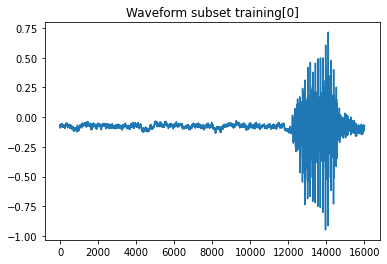

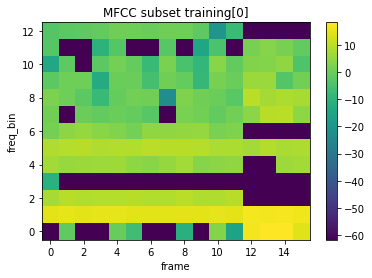

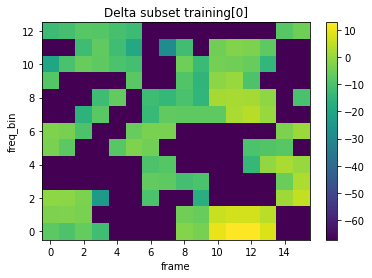

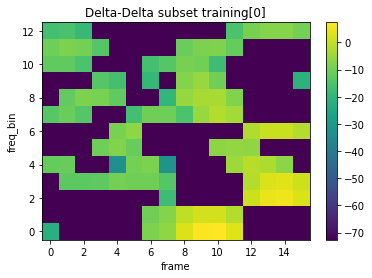

In [ ]:
train_dataset.plot_wf_and_features(0)

# Modelos

In [5]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [6]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, (h, c) = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [7]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

#Entrenamiento

## Funciones para entrenar

In [8]:
import time

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

In [9]:
def show_curves(all_curves):

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def get_metrics_and_confusion_matrix(model, dataset):
    model.cpu()
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=min(16, len(dataset)))
    y_true = []
    y_pred = []
    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    
    fig, ax = plt.subplots(figsize=(8, 7))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, xticks_rotation="vertical", include_values=False, ax=ax)
    plt.show()

In [10]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [11]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    n_evaluations_per_epoch=6,
    use_gpu=False,
):
    if use_gpu:
        model.cuda()


    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    print(n_batches)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / examples_count
                train_acc = cumulative_train_corrects / examples_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)


        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

## Entrenamiento con ventanas de 2048

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_2048 = Create_DataSet("training", 2048)
val_dataset_2048 = Create_DataSet("validation", 2048)
test_dataset_2048 = Create_DataSet("testing", 2048)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.5063905599969543, Train acc: 0.04729920814479638
Iteration 1766 - Batch 1766/5303 - Train loss: 3.470137124690351, Train acc: 0.05655772495755518
Iteration 2649 - Batch 2649/5303 - Train loss: 3.432523039961761, Train acc: 0.06408018867924528
Iteration 3532 - Batch 3532/5303 - Train loss: 3.3741070174172143, Train acc: 0.0753785734503255
Iteration 4415 - Batch 4415/5303 - Train loss: 3.3066015112335267, Train acc: 0.08677253170289854
Iteration 5298 - Batch 5298/5303 - Train loss: 3.248208191152293, Train acc: 0.09835582185317984
Val loss: 2.8793603836707775, Val acc: 0.16581504859232543
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 2.88077525126988, Train acc: 0.16890554298642535
Iteration 7069 - Batch 1766/5303 - Train loss: 2.8520338029327132, Train acc: 0.17214912280701755
Iteration 7952 - Batch 2649/5303 - Train loss: 2.8229352960046734, Train acc: 0.1772877358490566
Iteration 8835 - Batch 3532/5303 - Train l

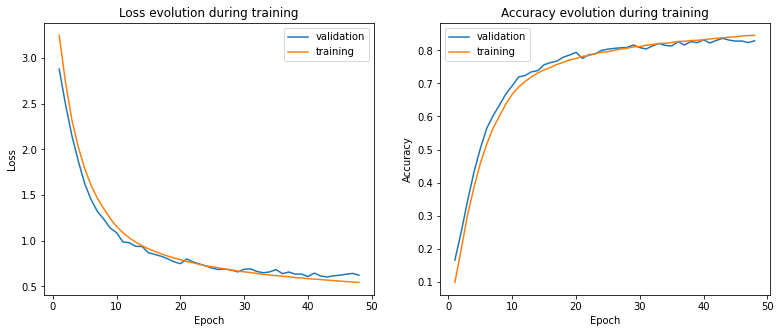

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_2048 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 80.15%


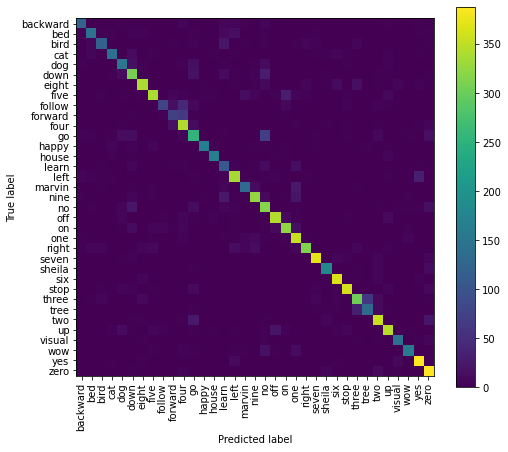

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_2048, test_dataset_2048)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.4363888550667743, Train acc: 0.07282239819004525
Iteration 1766 - Batch 1766/5303 - Train loss: 3.2654498449205747, Train acc: 0.12949207696661008
Iteration 2649 - Batch 2649/5303 - Train loss: 3.062787881527307, Train acc: 0.18964622641509435
Iteration 3532 - Batch 3532/5303 - Train loss: 2.8627596988983, Train acc: 0.2460196716671384
Iteration 4415 - Batch 4415/5303 - Train loss: 2.6852464628932267, Train acc: 0.2943699048913043
Iteration 5298 - Batch 5298/5303 - Train loss: 2.5238977638611955, Train acc: 0.33867239101717306
Val loss: 1.5562030181128974, Val acc: 0.5978358881875564
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 1.5254746404438537, Train acc: 0.6030825791855203
Iteration 7069 - Batch 1766/5303 - Train loss: 1.452846200404089, Train acc: 0.6190577249575552
Iteration 7952 - Batch 2649/5303 - Train loss: 1.3792407331151781, Train acc: 0.6369811320754717
Iteration 8835 - Batch 3532/5303 - Train loss:

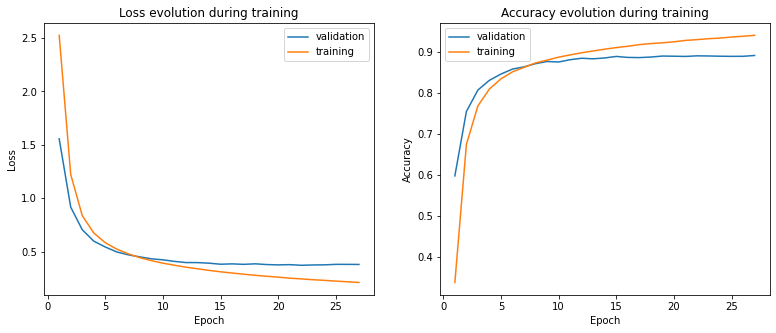

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_2048 = LSTMModel(13)

    curves, total_time = train_model(
        model_lstm_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 87.94%


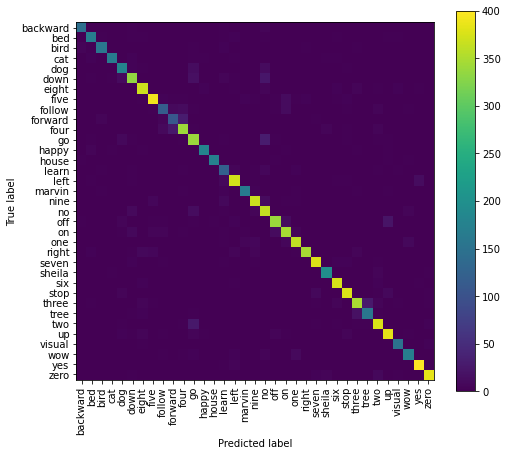

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_2048, test_dataset_2048)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.3217101833399605, Train acc: 0.12372737556561086
Iteration 1766 - Batch 1766/5303 - Train loss: 3.116419136423004, Train acc: 0.19043576683644595
Iteration 2649 - Batch 2649/5303 - Train loss: 2.903010786389405, Train acc: 0.24610849056603773
Iteration 3532 - Batch 3532/5303 - Train loss: 2.708918397297712, Train acc: 0.29634871214265496
Iteration 4415 - Batch 4415/5303 - Train loss: 2.530506963531176, Train acc: 0.34253283514492755
Iteration 5298 - Batch 5298/5303 - Train loss: 2.372772971837785, Train acc: 0.383834214002642
Val loss: 1.4026232655964923, Val acc: 0.6373108906923154
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 1.375691612516593, Train acc: 0.6486849547511312
Iteration 7069 - Batch 1766/5303 - Train loss: 1.2985213088597964, Train acc: 0.6669142614601019
Iteration 7952 - Batch 2649/5303 - Train loss: 1.243363950961041, Train acc: 0.6788679245283019
Iteration 8835 - Batch 3532/5303 - Train loss: 1

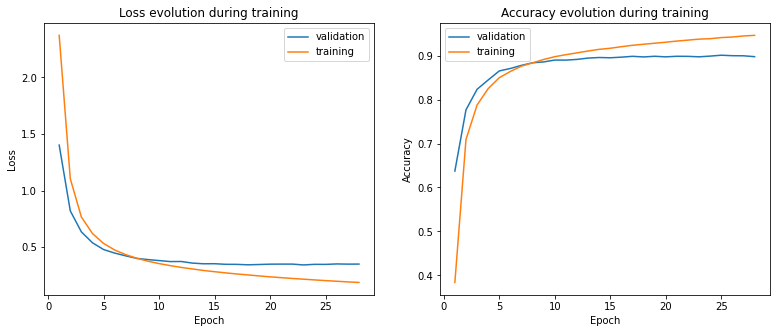

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_2048 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 89.67%


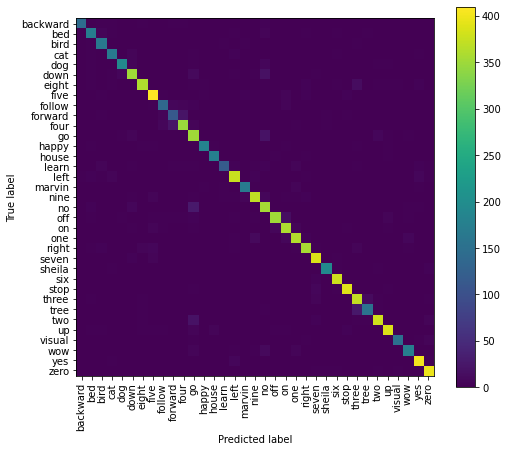

In [ ]:
get_metrics_and_confusion_matrix(model_gru_2048, test_dataset_2048)

## Entrenamiento con ventanas de 1024

In [12]:
# Create training, validation and testing split of the data.

train_dataset_1024 = Create_DataSet("training", 1024)
val_dataset_1024 = Create_DataSet("validation", 1024)
test_dataset_1024 = Create_DataSet("testing", 1024)

2652
Epoch 1/50
Iteration 442 - Batch 442/2652 - Train loss: 3.528621465842288, Train acc: 0.03738713318284424
Iteration 884 - Batch 884/2652 - Train loss: 3.505772649635703, Train acc: 0.04117231638418079
Iteration 1326 - Batch 1326/2652 - Train loss: 3.495966138925962, Train acc: 0.04321307460437076
Iteration 1768 - Batch 1768/2652 - Train loss: 3.488359855082562, Train acc: 0.045488270209157716
Iteration 2210 - Batch 2210/2652 - Train loss: 3.480154293686596, Train acc: 0.04791383989145183
Val loss: 3.4319047508396445, Val acc: 0.0651237350966837
Epoch 2/50
Iteration 3094 - Batch 442/2652 - Train loss: 3.42359361207243, Train acc: 0.06214729119638826
Iteration 3536 - Batch 884/2652 - Train loss: 3.416586023535432, Train acc: 0.06433615819209039
Iteration 3978 - Batch 1326/2652 - Train loss: 3.4044193163255865, Train acc: 0.06770440844009043
Iteration 4420 - Batch 1768/2652 - Train loss: 3.374520793077028, Train acc: 0.07285189372526851
Iteration 4862 - Batch 2210/2652 - Train loss: 

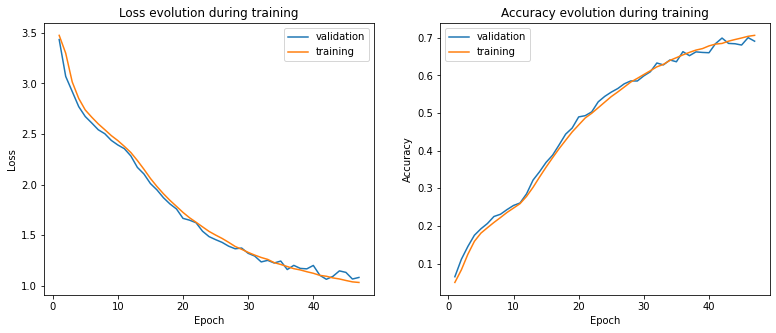

In [ ]:
lr = 1e-4 
batch_size = 32
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_1024 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 68.88%


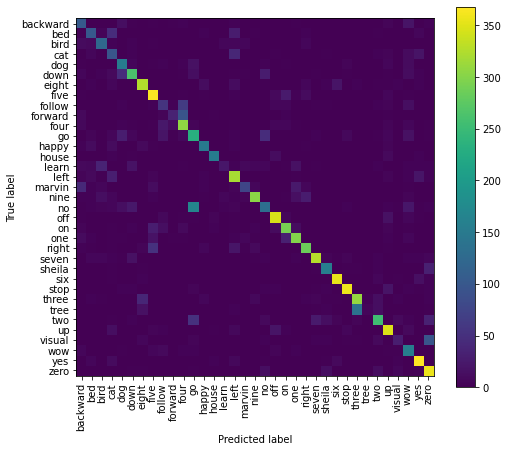

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_1024, test_dataset_1024)

2652
Epoch 1/50
Iteration 442 - Batch 442/2652 - Train loss: 3.4786125182029086, Train acc: 0.05847911963882618
Iteration 884 - Batch 884/2652 - Train loss: 3.3898252942467813, Train acc: 0.0981638418079096
Iteration 1326 - Batch 1326/2652 - Train loss: 3.2890230763111243, Train acc: 0.13128767897513188
Iteration 1768 - Batch 1768/2652 - Train loss: 3.1819017928087354, Train acc: 0.16230921424533634
Iteration 2210 - Batch 2210/2652 - Train loss: 3.07249820237783, Train acc: 0.1912737449118046
Val loss: 2.2683041675596485, Val acc: 0.39374812143071836
Epoch 2/50
Iteration 3094 - Batch 442/2652 - Train loss: 2.204488145847622, Train acc: 0.40399266365688485
Iteration 3536 - Batch 884/2652 - Train loss: 2.1225043777692116, Train acc: 0.4293785310734463
Iteration 3978 - Batch 1326/2652 - Train loss: 2.0501263642005663, Train acc: 0.450146006028636
Iteration 4420 - Batch 1768/2652 - Train loss: 1.971640561043441, Train acc: 0.4714881288863765
Iteration 4862 - Batch 2210/2652 - Train loss: 1

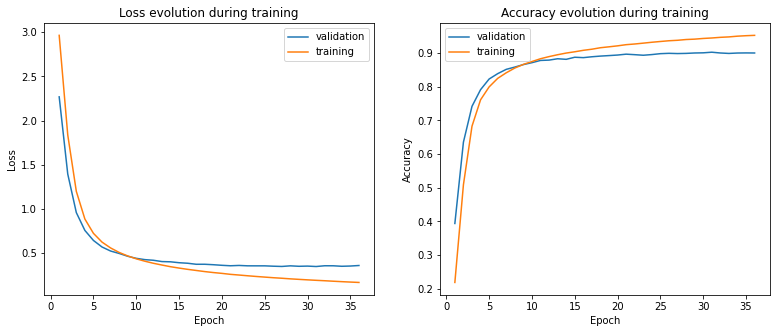

In [13]:
lr = 1e-4 
batch_size = 32
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_1024 = LSTMModel(13)

    curves, total_time = train_model(
        model_lstm_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 88.46%


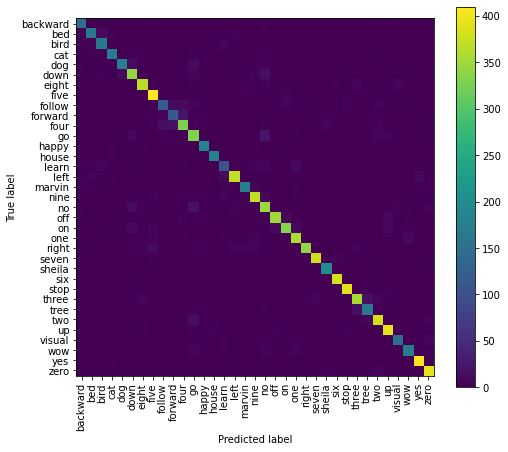

In [14]:
get_metrics_and_confusion_matrix(model_lstm_1024, test_dataset_1024)

2652
Epoch 1/50
Iteration 442 - Batch 442/2652 - Train loss: 3.431358678615389, Train acc: 0.09099887133182845
Iteration 884 - Batch 884/2652 - Train loss: 3.2558861492717335, Train acc: 0.14932909604519773
Iteration 1326 - Batch 1326/2652 - Train loss: 3.0963031864741195, Train acc: 0.19124434815373023
Iteration 1768 - Batch 1768/2652 - Train loss: 2.9476100839148005, Train acc: 0.23055045223289994
Iteration 2210 - Batch 2210/2652 - Train loss: 2.816251844100314, Train acc: 0.2655613975576662
Val loss: 1.9220673167243318, Val acc: 0.5251978759643322
Epoch 2/50
Iteration 3094 - Batch 442/2652 - Train loss: 1.8599494329693624, Train acc: 0.5308267494356659
Iteration 3536 - Batch 884/2652 - Train loss: 1.773029449834662, Train acc: 0.5515889830508475
Iteration 3978 - Batch 1326/2652 - Train loss: 1.6906680836206822, Train acc: 0.5712839110776187
Iteration 4420 - Batch 1768/2652 - Train loss: 1.6159575626700526, Train acc: 0.5885210570944036
Iteration 4862 - Batch 2210/2652 - Train loss: 

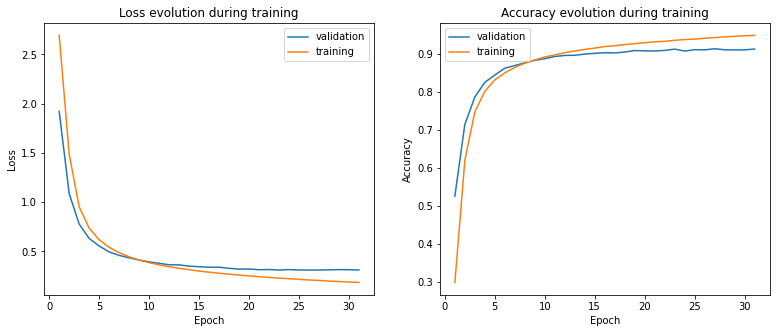

In [15]:
lr = 1e-4 
batch_size = 32
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_1024 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 90.11%


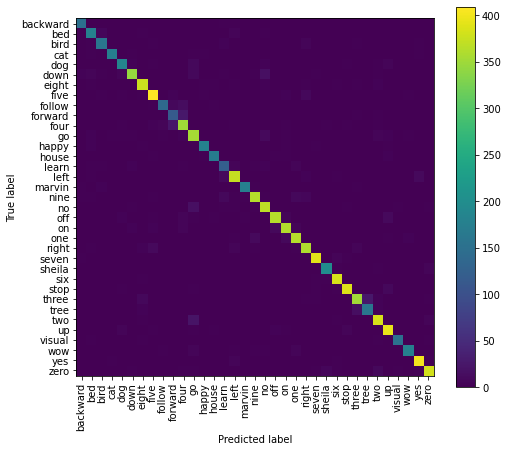

In [16]:
get_metrics_and_confusion_matrix(model_gru_1024, test_dataset_1024)

## Entrenamiento con ventanas de 512

In [17]:
# Create training, validation and testing split of the data.

train_dataset_512 = Create_DataSet("training", 512)
val_dataset_512 = Create_DataSet("validation", 512)
test_dataset_512 = Create_DataSet("testing", 512)

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.538258581161499, Train acc: 0.03865961199294533
Iteration 448 - Batch 448/1347 - Train loss: 3.5174609483748607, Train acc: 0.0400537349312405
Iteration 672 - Batch 672/1347 - Train loss: 3.5055801280363177, Train acc: 0.04155758390528078
Iteration 896 - Batch 896/1347 - Train loss: 3.4978337819493865, Train acc: 0.04319513015165189
Iteration 1120 - Batch 1120/1347 - Train loss: 3.491561302003001, Train acc: 0.044687991164351556
Iteration 1344 - Batch 1344/1347 - Train loss: 3.4862171722610644, Train acc: 0.04626187525815779
Val loss: 3.4538468525579535, Val acc: 0.06031459773569783
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 3.4534328799777563, Train acc: 0.055097001763668434
Iteration 1795 - Batch 448/1347 - Train loss: 3.4505170384600325, Train acc: 0.057234772156821156
Iteration 2019 - Batch 672/1347 - Train loss: 3.449017816277174, Train acc: 0.05660510861105215
Iteration 2243 - Batch 896/1347 - Train loss

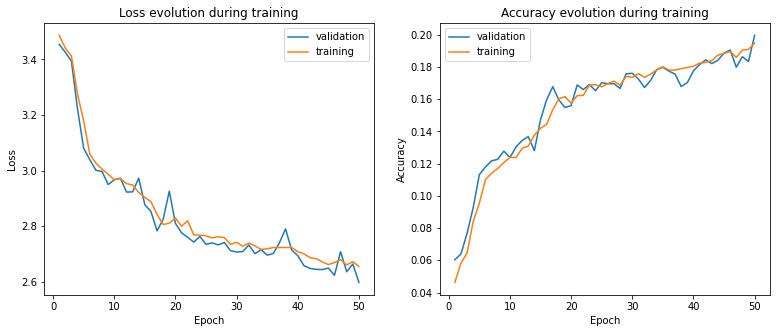

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_512 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 20.20%


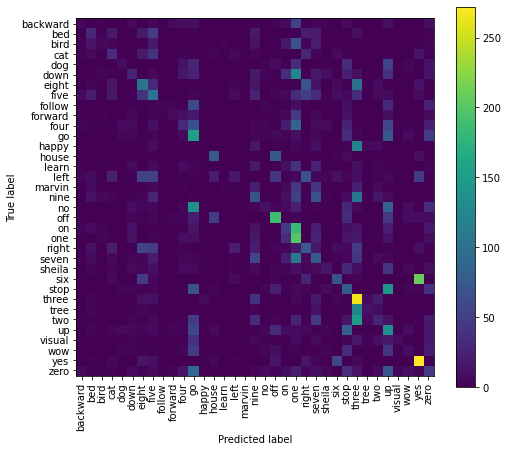

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_512, test_dataset_512)

1347
Epoch 1/50
Iteration 224 - Batch 224/1347 - Train loss: 3.506684272554186, Train acc: 0.049805996472663136
Iteration 448 - Batch 448/1347 - Train loss: 3.444188787570775, Train acc: 0.07632481351857744
Iteration 672 - Batch 672/1347 - Train loss: 3.384655545051881, Train acc: 0.09750229958253732
Iteration 896 - Batch 896/1347 - Train loss: 3.3199409872393146, Train acc: 0.11933959760046717
Iteration 1120 - Batch 1120/1347 - Train loss: 3.253278492179755, Train acc: 0.13778797275675064
Iteration 1344 - Batch 1344/1347 - Train loss: 3.1845942199451773, Train acc: 0.15395055172006844
Val loss: 2.7365814254991205, Val acc: 0.2745215910229436
Epoch 2/50
Iteration 1571 - Batch 224/1347 - Train loss: 2.708553834491306, Train acc: 0.26292768959435625
Iteration 1795 - Batch 448/1347 - Train loss: 2.652783020036523, Train acc: 0.2792802347368049
Iteration 2019 - Batch 672/1347 - Train loss: 2.59588423703436, Train acc: 0.2953371541781646
Iteration 2243 - Batch 896/1347 - Train loss: 2.54161

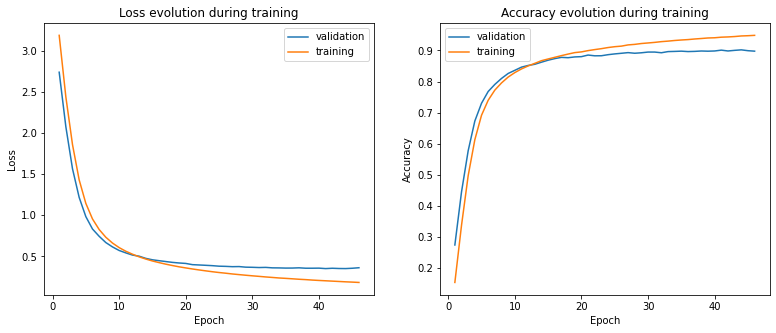

In [ ]:
lr = 1e-4 
batch_size = 63
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_512 = LSTMModel(13)

    curves, total_time = train_model(
        model_lstm_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 87.86%


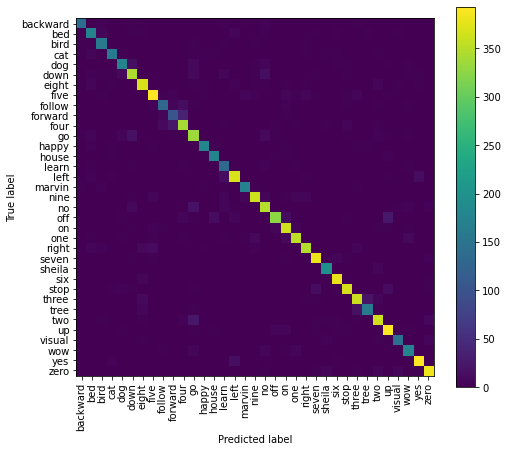

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_512, test_dataset_512)

6527
Epoch 1/50
Iteration 1087 - Batch 1087/6527 - Train loss: 3.2989888246006824, Train acc: 0.13786764705882354
Iteration 2174 - Batch 2174/6527 - Train loss: 3.0332561332329937, Train acc: 0.2183554376657825
Iteration 3261 - Batch 3261/6527 - Train loss: 2.8174021521059007, Train acc: 0.2732396359005801
Iteration 4348 - Batch 4348/6527 - Train loss: 2.6227022214548756, Train acc: 0.3237525868015636
Iteration 5435 - Batch 5435/6527 - Train loss: 2.443560262082516, Train acc: 0.36996943453897096
Iteration 6522 - Batch 6522/6527 - Train loss: 2.2856023600729043, Train acc: 0.41058267196547127
Val loss: 1.3193254277039932, Val acc: 0.667768760645226
Epoch 2/50
Iteration 7614 - Batch 1087/6527 - Train loss: 1.2784893411376022, Train acc: 0.6727234162895928
Iteration 8701 - Batch 2174/6527 - Train loss: 1.200968028923561, Train acc: 0.6901149425287356
Iteration 9788 - Batch 3261/6527 - Train loss: 1.1467329217823352, Train acc: 0.7015752487855492
Iteration 10875 - Batch 4348/6527 - Train 

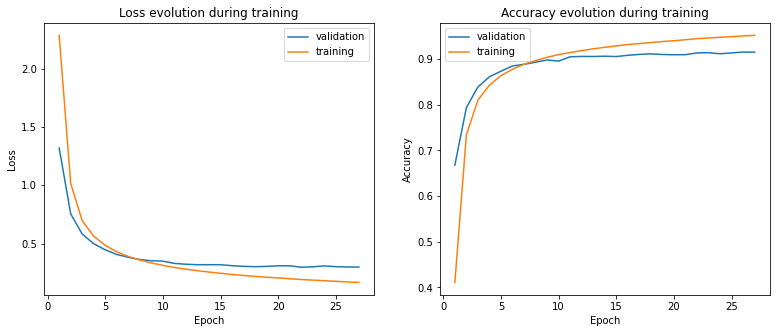

In [18]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_512 = GRUModel(13)

    curves, total_time = train_model(
        model_gru_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 91.10%


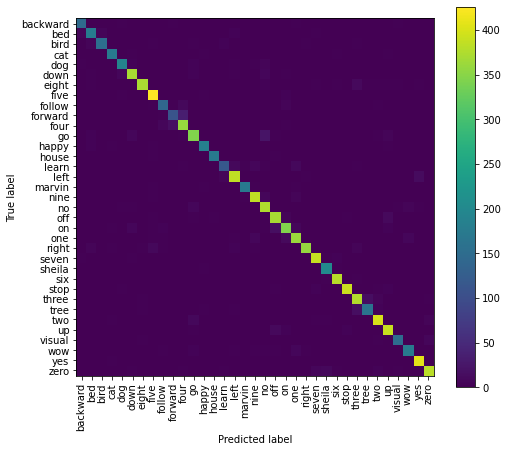

In [19]:
get_metrics_and_confusion_matrix(model_gru_512, test_dataset_512)

# Audios con Ruido

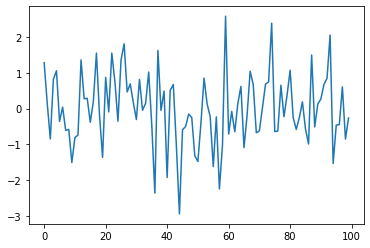

In [ ]:
noise = np.random.normal(0,1,100)
plt.plot(noise)

SMR in dB =  22.992439699783176
Average Noise power in dB =  7.992439699783176


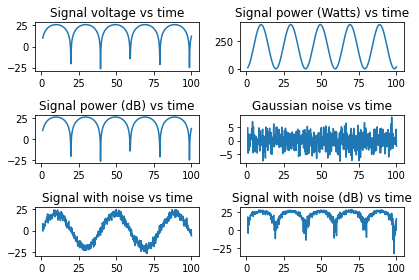

In [ ]:
target_snr_db = 15 # Desired target SNR in dB

# sine waveform generation with time vector
t = np.linspace(1, 100, 750)
x_volts = 20*np.sin(t/(2*np.pi))
x_watts = x_volts ** 2
x_db = 10 * np.log10(x_watts)

# Calculate signal power and convert to dB
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
print("SMR in dB = ", sig_avg_db)

# Calculate noise and convert it to watts
noise_avg_db = sig_avg_db - target_snr_db
print("Average Noise power in dB = ", noise_avg_db)
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate samples of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))

# Add noise to original sine waveform signal
y_volts = x_volts + noise_volts

# Plots in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)

# Plots
figure, axis = plt.subplots(3, 2)
axis[0,0].plot(t, x_db)
axis[0,0].set_title("Signal voltage vs time")
axis[0,1].plot(t, x_watts)
axis[0,1].set_title("Signal power (Watts) vs time")
axis[1,0].plot(t, x_db)
axis[1,0].set_title("Signal power (dB) vs time")
axis[1,1].plot(t, noise_volts)
axis[1,1].set_title("Gaussian noise vs time")
axis[2,0].plot(t, y_volts)
axis[2,0].set_title("Signal with noise vs time")
axis[2,1].plot(t, y_db)
axis[2,1].set_title("Signal with noise (dB) vs time")
plt.tight_layout()
plt.show()

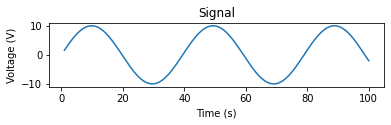

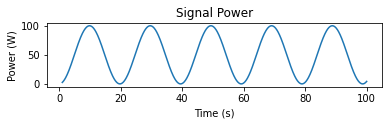

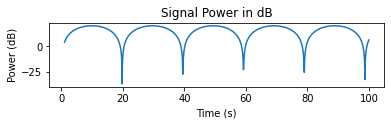

In [ ]:
# Signal Generation
# matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
# plt.subplot(3,1,1)
# plt.plot(t, x_volts)
# plt.title('Signal')
# plt.ylabel('Voltage (V)')
# plt.xlabel('Time (s)')
# plt.show()

x_watts = x_volts ** 2
# plt.subplot(3,1,2)
# plt.plot(t, x_watts)
# plt.title('Signal Power')
# plt.ylabel('Power (W)')
# plt.xlabel('Time (s)')
# plt.show()

x_db = 10 * np.log10(x_watts)
# plt.subplot(3,1,3)
# plt.plot(t, x_db)
# plt.title('Signal Power in dB')
# plt.ylabel('Power (dB)')
# plt.xlabel('Time (s)')
# plt.show()

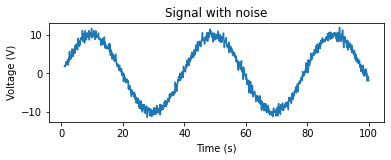

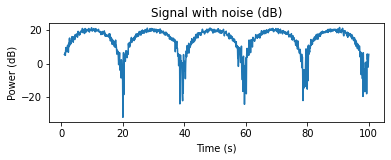

In [ ]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 20
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

"""
# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()
"""

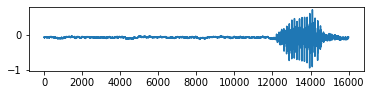

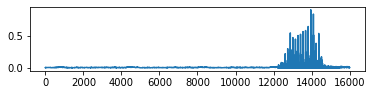

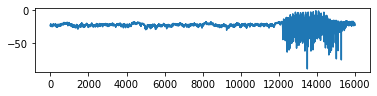

In [ ]:
signal = train_dataset.get_waveform(0).t().numpy()
signal_watts = signal ** 2
signal_db = 10 * np.log10(signal_watts)

plt.subplot(3,1,1)
plt.plot(signal)
plt.show()
plt.subplot(3,1,2)
plt.plot(signal_watts)
plt.show()
plt.subplot(3,1,3)
plt.plot(signal_db)
plt.show()

In [ ]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 15
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(signal_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(signal_watts))
# Noise up the original signal
y_volts = signal + noise_volts


# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(y_volts)
plt.title('Signal with noise')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.show()


In [ ]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

  0%|          | 0.00/427k [00:00<?, ?B/s]

  0%|          | 0.00/31.3k [00:00<?, ?B/s]

  0%|          | 0.00/53.2k [00:00<?, ?B/s]

  0%|          | 0.00/78.2k [00:00<?, ?B/s]

In [ ]:
#speech, _ = torchaudio.load(SAMPLE_SPEECH)
#noise, _ = torchaudio.load(SAMPLE_NOISE)
#noise = noise[:, : speech.shape[1]]


signal = train_dataset.get_waveform(0)
noise = torch.randn(signal.shape)

speech_rms = signal.norm(p=2)
noise_rms = noise.norm(p=2)

snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = 10 ** (snr_db / 20)
    scale = snr * noise_rms / speech_rms
    noisy_speeches.append((scale * signal + noise) / 2)

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

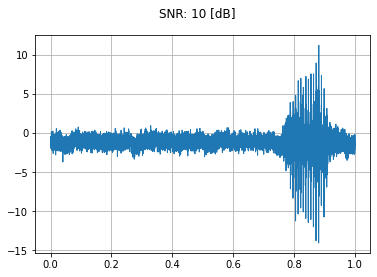

In [ ]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, 16000, title=f"SNR: {snr_db} [dB]")

#código para hacer señales con ruido

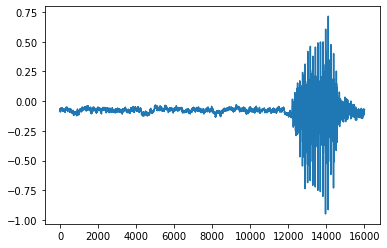

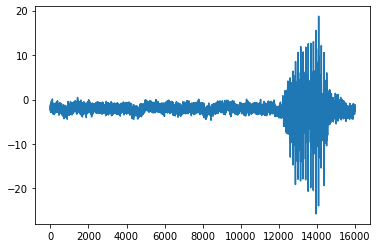

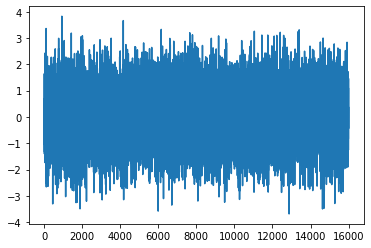

In [ ]:
signal = train_dataset.get_waveform(0)
noise = torch.randn(signal.shape)

speech_rms = signal.norm(p=2)
noise_rms = noise.norm(p=2)

snr_db = 15
noisy_speeches = []

snr = 10 ** (snr_db / 20)
scale = snr * noise_rms / speech_rms
# noisy_speeches.append((scale * signal + noise) / 2)
noisy = (scale * signal + noise) / 2

plt.plot(signal.t().numpy())
plt.show()
plt.plot(noisy.t().numpy())
plt.show()
plt.plot(noise.t().numpy())
plt.show()

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Spectrogram (db)")
  axs.set_ylabel(ylabel)
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



class Create_DataSet_Noisy(SPEECHCOMMANDS):
  def __init__(self, subset: str = None, ventanas: int = 2048):
    super().__init__("./", download=True)

    self.ventanas = ventanas
    self.subset = subset

    def load_list(filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as fileobj:
            return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

    if subset == "validation":
        self._walker = load_list("validation_list.txt")
    elif subset == "testing":
        self._walker = load_list("testing_list.txt")
    elif subset == "training":
        excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
        excludes = set(excludes)
        self._walker = [w for w in self._walker if w not in excludes]


  def get_item_info(self, filepath: str, path: str):
      relpath = os.path.relpath(filepath, path)
      label, filename = os.path.split(relpath)
      speaker, _ = os.path.splitext(filename)
      speaker, _ = os.path.splitext(speaker)

      speaker_id, utterance_number = speaker.split("_nohash_")
      utterance_number = int(utterance_number)

      # Load audio
      waveform, sample_rate = torchaudio.load(filepath)

      largo = waveform.shape[1]
      if largo != 16000:
        pad = (16000 - largo-1, 1)
        waveform = F.pad(waveform, pad, value=0)


      # Add noise
      noise = torch.randn(waveform.shape)

      waveform_rms = waveform.norm(p=2)
      noise_rms = noise.norm(p=2)

      snr_db = 15 #dB del SNR

      snr = 10 ** (snr_db / 20)
      scale = snr * noise_rms / waveform_rms
      
      waveform = (scale * waveform + noise) / 2


      # MFCC
      n_mfcc = 13
      n_fft = self.ventanas
      win_length = None
      hop_length = int(self.ventanas/2)
      n_mels = 13
      args={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "mel_scale": "htk"}

      mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=args)
      MFCC = mfcc_transform(waveform)


      # Delta
      delta_transform = T.ComputeDeltas()
      Delta = delta_transform(MFCC[0])


      # Delta Delta
      Delta_Delta = delta_transform(Delta)


      clase = torch.tensor(labels.index(label))

      return waveform, MFCC[0], Delta, Delta_Delta, clase





  def __getitem__(self, n: int):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)
    #return torch.cat((info[1], info[2], info[3]), 1), info[4]
    return info[1].T, info[4]


  def plot_wf_and_features(self, n):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    plt.plot(info[0].t().numpy())
    plt.title(f"Waveform subset {self.subset}[{n}]")
    plot_spectrogram(info[1], title = f"MFCC subset {self.subset}[{n}]")
    plot_spectrogram(info[2], title = f"Delta subset {self.subset}[{n}]")
    plot_spectrogram(info[3], title = f"Delta-Delta subset {self.subset}[{n}]")

  def get_waveform(self, n: int):
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    return info[0]

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_noisy = Create_DataSet_Noisy("training")
val_dataset_noisy = Create_DataSet_Noisy("validation")
test_dataset_noisy = Create_DataSet_Noisy("testing")

5303
Epoch 1/25
Iteration 883 - Batch 883/5303 - Train loss: 3.518586656356829, Train acc: 0.037259615384615384
Iteration 1766 - Batch 1766/5303 - Train loss: 3.502125448605808, Train acc: 0.04095925297113752
Iteration 2649 - Batch 2649/5303 - Train loss: 3.488948937901911, Train acc: 0.04587264150943396
Iteration 3532 - Batch 3532/5303 - Train loss: 3.4509709686454215, Train acc: 0.05476931786017549
Iteration 4415 - Batch 4415/5303 - Train loss: 3.396849992374579, Train acc: 0.06388700181159421
Iteration 5298 - Batch 5298/5303 - Train loss: 3.34270099375153, Train acc: 0.07363417625967164
Val loss: 2.9828019868800832, Val acc: 0.14026650636208796
Epoch 2/25
Iteration 6186 - Batch 883/5303 - Train loss: 2.9558833149763255, Train acc: 0.1390695701357466
Iteration 7069 - Batch 1766/5303 - Train loss: 2.9029654888494174, Train acc: 0.1524122807017544
Iteration 7952 - Batch 2649/5303 - Train loss: 2.8546554312616026, Train acc: 0.1619575471698113
Iteration 8835 - Batch 3532/5303 - Train lo

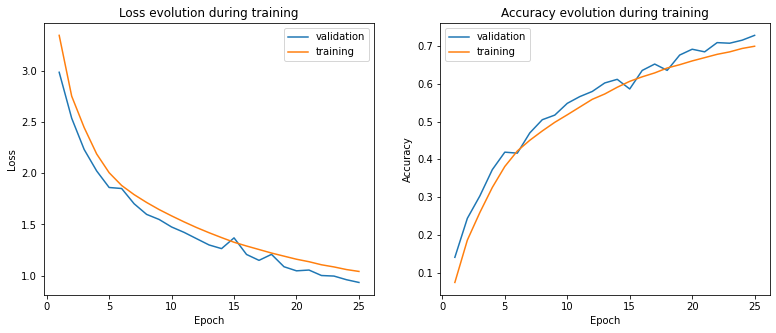

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_noisy = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_noisy,
        train_dataset_noisy,
        val_dataset_noisy,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 70.14%


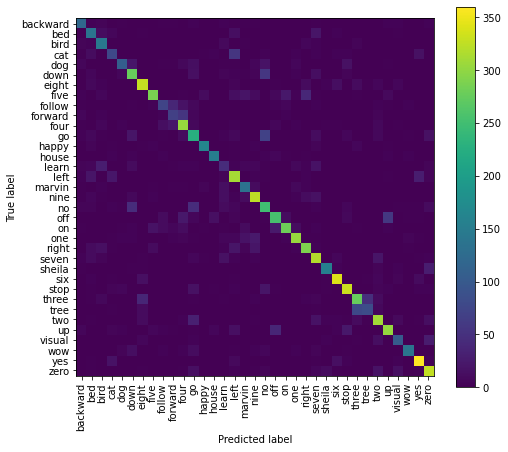

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_noisy, test_dataset_noisy)

### entrenamiento GRU con ventanas de 512 y ruido

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_noisy_512 = Create_DataSet_Noisy("training", 512)
val_dataset_noisy_512 = Create_DataSet_Noisy("validation", 512)
test_dataset_noisy_512 = Create_DataSet_Noisy("testing", 512)

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 15

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_noisy_512 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_noisy_512,
        train_dataset_noisy_512,
        val_dataset_noisy_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 17.92%


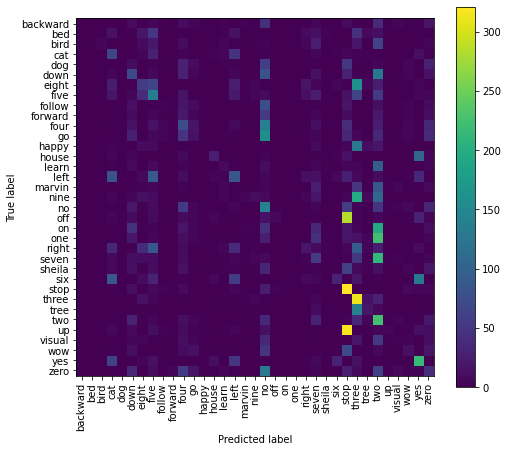

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_noisy_512, test_dataset_noisy_512)